<a href="https://colab.research.google.com/github/projectsforstudents2022/Named-Entity-Recognition/blob/main/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Import Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf

In [27]:
# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Loading Data

data= pd.read_csv("/content/drive/MyDrive/Projects/Named_Entity_Recognition/ner_dataset.csv",encoding="latin1")

In [29]:
# NULL Values

print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [30]:
#Filling Null Values

data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [31]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [32]:
#Storing unique words and tags as a list

words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [33]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)
num_words, num_tags

(35179, 17)

In [34]:
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]

In [35]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [36]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [37]:
# Define Mappings between Sentences and Tags

word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [38]:
word2idx

{'audit': 1,
 'rulings': 2,
 'Rodrigues': 3,
 'Zebra': 4,
 'revelry': 5,
 'capitol': 6,
 'link': 7,
 'accords': 8,
 'devices': 9,
 'grudges': 10,
 'Mihtarlam': 11,
 'first-class': 12,
 'Janata': 13,
 '73.83': 14,
 'disinfectant': 15,
 'Jazeera': 16,
 'AIE-coalition': 17,
 'Prevention': 18,
 'Kerguelen': 19,
 'affairs': 20,
 'high': 21,
 'perilous': 22,
 'billionaires': 23,
 'ransom': 24,
 'tuna': 25,
 'Mei': 26,
 'bloating': 27,
 'Alyaty': 28,
 'Nevada': 29,
 'Rahman': 30,
 'Jameson': 31,
 'Seine-Saint-Denis': 32,
 'write-off': 33,
 'counseling': 34,
 'patched': 35,
 'centenary': 36,
 'pervasive': 37,
 'Later': 38,
 'Netanya': 39,
 'Hilla': 40,
 'Kosachyov': 41,
 'Maddalena': 42,
 'maltreated': 43,
 'reopened': 44,
 'Problems': 45,
 'Leavitt': 46,
 'rain-fed': 47,
 'republic': 48,
 'Khobar': 49,
 'Filipchuk': 50,
 'six-year': 51,
 'Ljoekelsoey': 52,
 '220': 53,
 'Faroese': 54,
 'dissatisified': 55,
 'Andes': 56,
 'sacks': 57,
 'Bragg': 58,
 'celibacy': 59,
 'Kadkhodai': 60,
 'ligament'

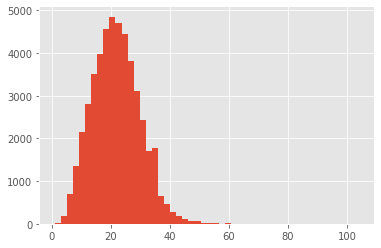

In [39]:
# Visualisation

plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [40]:
# Class & Label Split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
max_len = 50
X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)
y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [41]:
# Train Test Split

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

In [42]:
# Build and Compile a Bidirectional LSTM Model

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 17)           3417      
 tributed)                                                       
                                                           

In [43]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


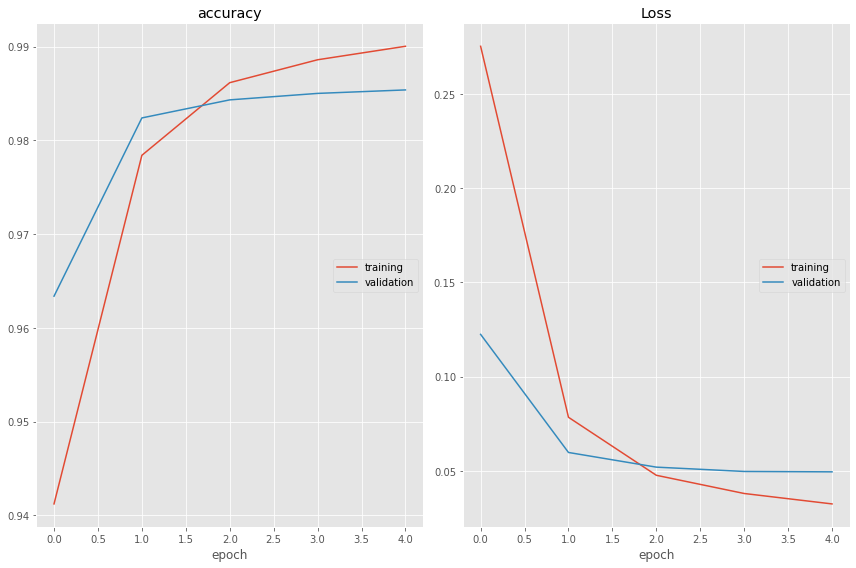

accuracy
	training         	 (min:    0.941, max:    0.990, cur:    0.990)
	validation       	 (min:    0.963, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.032, max:    0.275, cur:    0.032)
	validation       	 (min:    0.049, max:    0.122, cur:    0.049)
540/540 [==============================] - 183s 338ms/step - loss: 0.0324 - accuracy: 0.9900 - val_loss: 0.0494 - val_accuracy: 0.9854


In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

In [46]:
# Evaluate Model

model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 5s 31ms/step - loss: 0.0508 - accuracy: 0.9852


[0.05075972527265549, 0.9852168560028076]

In [47]:
# Prediction

i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

Word           True 	 Pred

------------------------------
The            O    	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O    	O
103            O    	O
nuclear        O    	O
power          O    	O
plants         O    	O
in             O    	O
31             O    	B-tim
states         O    	O
.              O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-born  O    	O
Jamaican-